In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data',header = None)
df_wine.columns = ['Class label', 'Alcohol',
 'Malic acid', 'Ash',
 'Alcalinity of ash', 'Magnesium',
 'Total phenols', 'Flavanoids',
 'Nonflavanoid phenols',
 'Proanthocyanins',
 'Color intensity', 'Hue',
 'OD280/OD315 of diluted wines',
 'Proline']

In [3]:
from sklearn.model_selection import train_test_split
X, y = df_wine.iloc[:,1:].values, df_wine.iloc[:,0].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3 , stratify = y, random_state = 0)
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
X_train_std, X_test_std = std.fit_transform(X_train), std.fit_transform(X_test)

In [4]:
np.set_printoptions(precision  = 4)
mean_vec = []
for label in range(1,4):
    mean_vec.append(np.mean(X_train_std[y_train == label], axis = 0))
    print('MV %s: %s\n' %(label, mean_vec[label-1]))

MV 1: [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]

MV 2: [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]

MV 3: [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]



In [5]:
mean_vec

[array([ 0.9066, -0.3497,  0.3201, -0.7189,  0.5056,  0.8807,  0.9589,
        -0.5516,  0.5416,  0.2338,  0.5897,  0.6563,  1.2075]),
 array([-0.8749, -0.2848, -0.3735,  0.3157, -0.3848, -0.0433,  0.0635,
        -0.0946,  0.0703, -0.8286,  0.3144,  0.3608, -0.7253]),
 array([ 0.1992,  0.866 ,  0.1682,  0.4148, -0.0451, -1.0286, -1.2876,
         0.8287, -0.7795,  0.9649, -1.209 , -1.3622, -0.4013])]

In [6]:
#Calculationg whithin class scatter matrices
d = 13 # number of feature
S_w = np.zeros((d,d))
for label, mv in zip(range(1,4), mean_vec):
    class_scatter = np.zeros((d,d))
    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(d,1), mv.reshape(d,1)
        class_scatter += (row - mv).dot((row - mv).T)
    S_w+=class_scatter
print("Whithin Class scatter matrix - %sx%s" %(S_w.shape[0], S_w.shape[1]))


Whithin Class scatter matrix - 13x13


In [7]:
#We are assuming that the class labels are uniformly distributed but that condition is violated
print("Class Label Distribution - ", np.bincount(y_train)[1:])

Class Label Distribution -  [41 50 33]


In [8]:
#So we need a scaled version of scater matrix
d = 13 # number of feature
S_w = np.zeros((d,d))
for label, mv in zip(range(1,4), mean_vec):
    class_scatter = np.cov(X_train_std[y_train == label].T)
    S_w+=class_scatter
print("Whithin Class scatter matrix - %sx%s" %(S_w.shape[0], S_w.shape[1]))


Whithin Class scatter matrix - 13x13


In [12]:
label

3

In [9]:
#Next we compute within class scatter matrix
mean_overall = np.mean(X_train_std, axis = 0)
d = 13
S_b = np.zeros((d,d))
for i, m_v in enumerate(mean_vec):
    n = X_train_std[y_train == i+1].shape[1]
    m_v = m_v.reshape(d,1)
    mean_overall = mean_overall.reshape(d,1)
    S_b+= n*(m_v - mean_overall).dot((m_v - mean_overall).T)
print("Whithin Class scatter matrix - %sx%s" %(S_b.shape[0], S_b.shape[1]))

Whithin Class scatter matrix - 13x13


In [10]:
#Computing epairs for Sw-1Sb
eVal, eVec = np.linalg.eig(np.linalg.inv(S_w).dot(S_b))
ePairs = [(np.abs(eVal[i]), eVec[:,i]) for i in range(len(eVal))] 
ePairs.sort(key = lambda k:k[0], reverse = True) # sorting the tuples in decreasing order of e-vals
print('Eigenvalues in descending order:\n')
for eV in ePairs:
    print(eV[0])

Eigenvalues in descending order:

126.04694584819556
50.8763651059293
7.769328236415134e-15
6.56745019227536e-15
6.56745019227536e-15
5.7443765069317345e-15
5.4969424111074125e-15
4.9090210310908164e-15
2.7760286725854775e-15
2.7760286725854775e-15
1.4570319153886209e-15
4.2304823786284926e-16
0.0


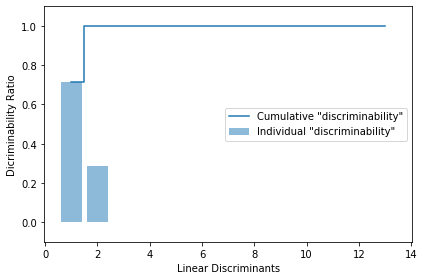

In [11]:
tot = sum(eVal.real)
discr = [(i/tot) for i in sorted(eVal.real, reverse=True)]
cum_discr = np.cumsum(discr)
plt.bar(range(1, 14), discr, alpha=0.5, align='center', label='Individual "discriminability"')
plt.step(range(1, 14), cum_discr, where='mid', label='Cumulative "discriminability"')
plt.ylabel("Dicriminability Ratio")
plt.xlabel("Linear Discriminants")
plt.ylim([-0.1,1.1])
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

In [37]:
w = np.hstack((ePairs[0][1][:, np.newaxis],
              ePairs[1][1][:, np.newaxis]))
w

array([[-0.1229+0.j, -0.4193+0.j],
       [ 0.1009+0.j, -0.1458+0.j],
       [ 0.0053+0.j, -0.3506+0.j],
       [ 0.1287+0.j,  0.3337+0.j],
       [-0.0113+0.j, -0.0823+0.j],
       [ 0.1866+0.j,  0.1035+0.j],
       [-0.7535+0.j,  0.1999+0.j],
       [-0.0746+0.j, -0.018 +0.j],
       [-0.0038+0.j,  0.0896+0.j],
       [ 0.3083+0.j, -0.1808+0.j],
       [-0.0501+0.j,  0.2674+0.j],
       [-0.3549+0.j, -0.0502+0.j],
       [-0.3554+0.j, -0.6294+0.j]])

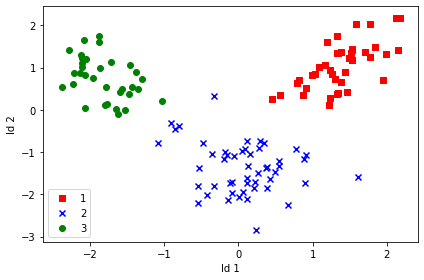

In [41]:
colors = ['r','b','g']
markers = ['s', 'x', 'o']
X_train_lda = (-1)*(X_train_std.dot(w))
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train == l, 0],X_train_lda[y_train == l, 1],c = c, label = l,marker = m)
plt.xlabel('ld 1')
plt.ylabel('ld 2')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

In [42]:
from matplotlib.colors import ListedColormap
def plotDecisionRegion(X, y, classifier, test_idx = None, resolution = 0.02):
    markers = ('s','x','o','^','v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    x1_min, x1_max = X[:, 0].min() - 1,X[:,0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1,X[:,1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min,x1_max,resolution),
                          np.arange(x2_min,x2_max, resolution))
    #xx1, xx2 are the coordinates of x and y respectively, we pair each value of the two corresponding matrices and get a grid
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1,xx2, Z, alpha = 0.3, cmap = cmap)
    plt.xlim(xx1.min(),xx1.max())
    plt.ylim(xx2.min(),xx2.max())
    
    for idx, c1 in enumerate(np.unique(y)):
        plt.scatter(x =X[y==c1,0],
                    y = X[y==c1,1],
                    alpha =0.8,
                    c = colors[idx],
                    marker = markers[idx],
                    label = c1, edgecolor='black')
    
    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:,0], X_test[:,1], c= '', edgecolors='black',
                    alpha=1.0, linewidths=1, marker='o', s=100, label='test set')

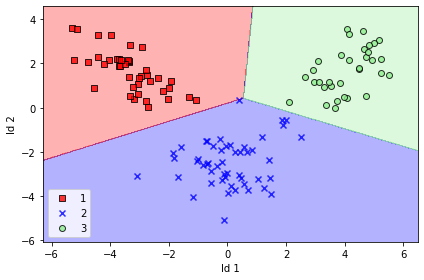

In [44]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)
lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
lr.fit(X_train_lda, y_train)
plotDecisionRegion(X_train_lda, y_train, classifier=lr)
plt.xlabel('ld 1')
plt.ylabel('ld 2')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

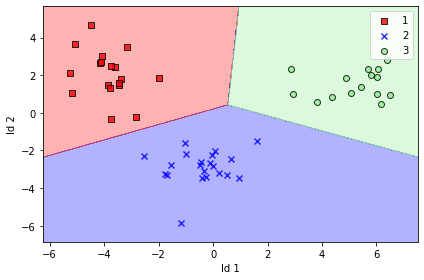

In [47]:
X_test_lda = lda.fit_transform(X_test_std, y_test)
plotDecisionRegion(X_test_lda, y_test, classifier=lr)
plt.xlabel('ld 1')
plt.ylabel('ld 2')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

In [ ]:
lr.score()